### Install arcos4py from pypi

In [ ]:
! pip install arcos4py

### Import packages

In [18]:
import pandas as pd
from arcos4py import ARCOS
TAB20 = [
    "#1f77b4",
    "#aec7e8",
    "#ff7f0e",
    "#ffbb78",
    "#2ca02c",
    "#98df8a",
    "#d62728",
    "#ff9896",
    "#9467bd",
    "#c5b0d5",
    "#8c564b",
    "#c49c94",
    "#e377c2",
    "#f7b6d2",
    "#7f7f7f",
    "#c7c7c7",
    "#bcbd22",
    "#dbdb8d",
    "#17becf",
    "#9edae5",
]

### Example Dataset

The synthetic dataset contains 81 objects spaced on a 2D 9x9 lattice. Each object has an ID (column id) and can assume values 0 and 1 (column m), which correspond to an inactive and active state. The evolution of active states takes place over 8 consecutive time points (column t). Each cell moves slightly over time, hence a light wiggle around the initial position.

dataset location: arcos4py/sample_data/arcos_data.csv"

For an in-depth explanation of the parameters check out the documentation

### Set variables for loading and processing of the data

For an in-depth explanation of the parameters check out the documentation

In [6]:
# path to data
DATA: str = "sample_data/arcos_data.csv"

# column names in DATA
POSITION_COLUMN_NAMES: list = ['x', 'y']
FRAME_COLUMN_NAME: str = "t"
OBJECT_ID_COLUMN_NAME: str = None
MEASUREMENT_COLUMN_NAME: str = "m"

# column name with collective event track ids
COLLID_COLUMN_NAME: str = "collid"

# values for clipping and interpolation
INTERPOLATE: bool = False
CLIP: bool = False
CLIP_LOW: float = 0.001
CLIP_HIGH: float = 0.999

# binarization parameters
DETRENDING_METHOD: str = "none"   # can be "none", "runmed" or "lm"
SMOOTHK: int = 3
BIASK: int = 25                     # needed only if BINARIZATION_METHOD method = runmed
PEAK_THRESHOLD: float = 0.5         # needed only if BINARIZATION_METHOD method = runmed
DEGREE_OF_POLYNOMIAL: int = 1       # needed only if BINARIZATION_METHOD method = lm
BINARIZATION_THRESHOLD: float = 0.5

# event detection parameters
EPS: float = 2
MIN_CLUSTER_SIZE: int = 2
NPREV_FRAMES: int = 1

# filter parameters
MIN_COLLECTIVE_EVENT_DURATION: int = 2
MIN_TOTAL_EVENT_SIZE: int = 5

### Load dataset

In [7]:
df = pd.read_csv(DATA)

# print first rows of data
df.head()

,t,x,y,m,id
0,1,0.228725,-0.158940,0,1
1,1,0.880323,-0.117712,0,2
2,1,1.930571,0.078604,0,3
3,1,2.958771,0.189801,0,4
4,1,3.902933,-0.041380,0,5


### Detect collective events

In [8]:
# create ARCOS object
ts = ARCOS(data=df, posCols=POSITION_COLUMN_NAMES, frame_column=FRAME_COLUMN_NAME, id_column=OBJECT_ID_COLUMN_NAME, measurement_column=MEASUREMENT_COLUMN_NAME, clid_column=COLLID_COLUMN_NAME)

# interpolate and clip if necessary
if INTERPOLATE:
    ts.interpolate_measurements() # interpolation of missing values, optional
if CLIP:
    ts.clip_meas(CLIP_LOW, CLIP_HIGH) # clipping of measurement value, optional

# detrend and binarize data
ts.bin_measurements(smoothK=SMOOTHK, biasK=BIASK, peakThr=PEAK_THRESHOLD, binThr=BINARIZATION_THRESHOLD, polyDeg=DEGREE_OF_POLYNOMIAL, biasMet=DETRENDING_METHOD) # detrending and binarization

# detect and track collective events
collev = ts.trackCollev(eps=EPS, minClsz=MIN_CLUSTER_SIZE, nPrev=NPREV_FRAMES)

# print first rows of detected collective events
collev.head()

9it [00:00, 232.30it/s]              

[0 2 2 1 4 1 5 5]
[0 6 5 5 4 7 6 4 3 3 0 1 1 2 0 1 7 7]
[ 1  5  6  0  5  7  7 16 14 17 12  0 15 15 11 12]
[ 5  8  9 10 12 14]
[ 3 11]


,t,x,y,m,id,m.resc,m.bin,collid
0,2,4.156989,3.914614,1,41,1,1,-1
1,3,4.933454,4.941598,1,51,1,1,1
2,3,5.060063,4.063136,1,42,1,1,1
3,3,3.837904,4.910511,1,50,1,1,1
4,3,3.997509,3.955390,1,41,1,1,1


In [12]:
collev_filtered = collev.query('collid == 1')

In [14]:
import napari
viewer = napari.Viewer()
import numpy as np

In [ ]:

viewer.add_points

In [19]:
np_data = collev_filtered[['t', 'y', 'x']].to_numpy()
colors = np.take(np.array(TAB20), collev_filtered['collid'].unique(), mode="wrap")
df_w_colors = pd.merge(collev_filtered, pd.DataFrame(data={'colors': colors, 'collid': collev_filtered['collid'].unique()}))
points_data = df_w_colors[['t', 'y', 'x']].to_numpy()
colors_data = df_w_colors['colors'].to_numpy('str')

In [21]:
# viewer.add_tracks(np_data, name='cell tracks')
viewer.add_points(points_data, face_color=colors_data, name='collective events')

<Points layer 'collective events' at 0x202b8f42f80>

## filter collective events

In [9]:
from arcos4py.tools import filterCollev

In [10]:
filterer = filterCollev(data = collev, frame_column= FRAME_COLUMN_NAME, collid_column=COLLID_COLUMN_NAME, obj_id_column=OBJECT_ID_COLUMN_NAME) # initialize class
collev_filtered = filterer.filter(coll_duration=MIN_COLLECTIVE_EVENT_DURATION, coll_total_size=MIN_TOTAL_EVENT_SIZE) #
collev_filtered.head()

KeyError: '[None] not in index'

### Collective event Stats

In [13]:
from arcos4py.tools import calcCollevStats

In [14]:
stats = calcCollevStats().calculate(collev_filtered, FRAME_COLUMN_NAME, COLLID_COLUMN_NAME, OBJECT_ID_COLUMN_NAME, POSITION_COLUMN_NAMES)
stats.head()

,collid,duration,total_size,min_size,max_size,start_frame,end_frame,first_frame_centroid,last_frame_centroid
0,1.0,5.0,25,6.0,17.0,3.0,7.0,"[4.134266850197441, 4.175572914818276]","[3.5866499957334064, 4.0094455099197175]"


### Plotting Module

In [15]:
from arcos4py import plotting

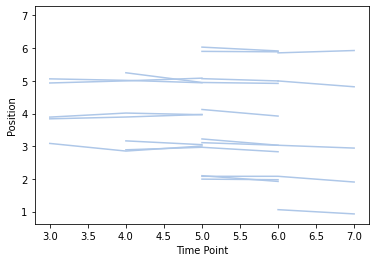

In [16]:
ndl = plotting.NoodlePlot(collev_filtered,COLLID_COLUMN_NAME, OBJECT_ID_COLUMN_NAME, FRAME_COLUMN_NAME, POSITION_COLUMN_NAMES[0], POSITION_COLUMN_NAMES[1])
ndl_plot = ndl.plot(POSITION_COLUMN_NAMES[0])

In [17]:
data_plots = plotting.dataPlots(df,FRAME_COLUMN_NAME, MEASUREMENT_COLUMN_NAME, OBJECT_ID_COLUMN_NAME)

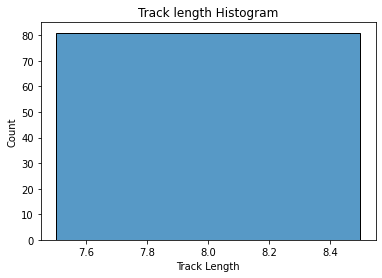

In [18]:
hist = data_plots.histogram()

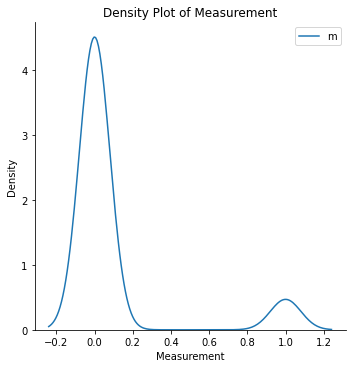

In [19]:
dens = data_plots.density_plot()

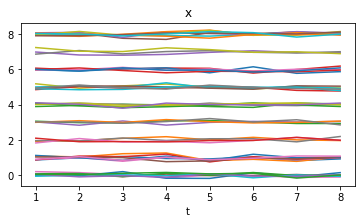

In [20]:
xt_plot = data_plots.position_t_plot({POSITION_COLUMN_NAMES[0]}, n=50)

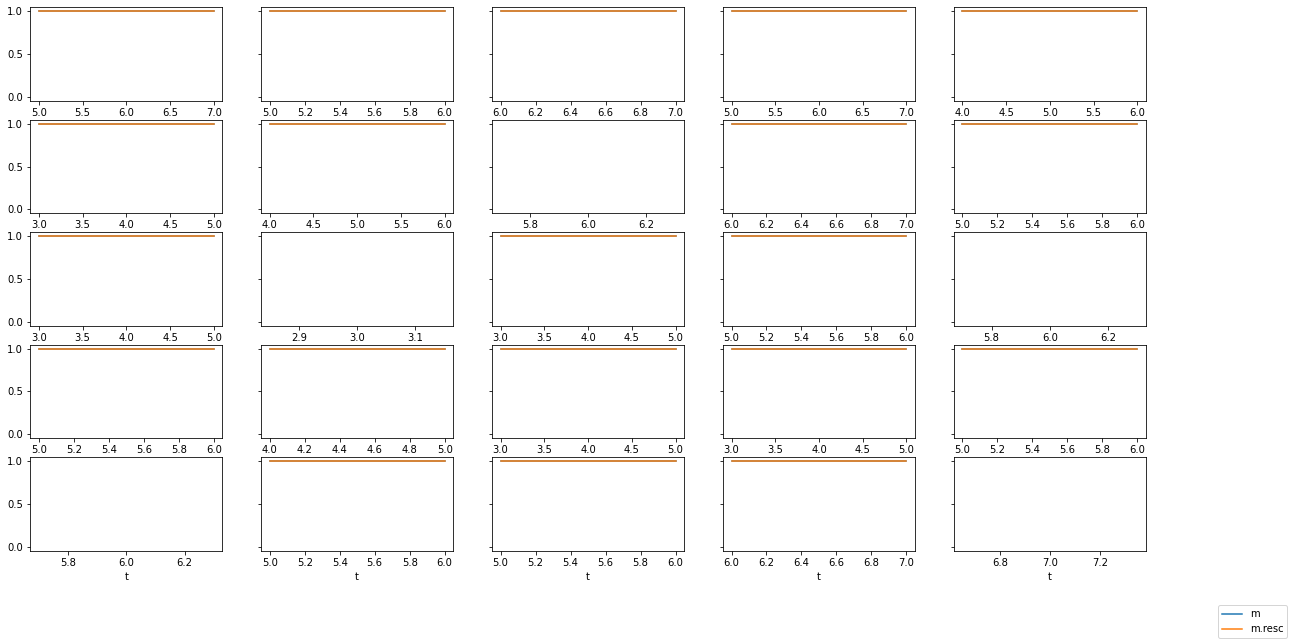

In [21]:
detrend_plot = plotting.plotOriginalDetrended(collev,FRAME_COLUMN_NAME, MEASUREMENT_COLUMN_NAME,f'{MEASUREMENT_COLUMN_NAME}.resc',OBJECT_ID_COLUMN_NAME).plot_detrended()

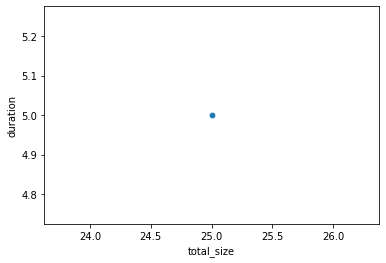

In [22]:
coll_dur_size_scatter = plotting.statsPlots(stats).plot_events_duration('total_size','duration')